In [221]:
import numpy as np
import pandas as pd
import sympy as sp
import Funciones_sismos as BN
from scipy.linalg import eig, eigh
import matplotlib.pyplot as plt

In [222]:
E = 1900000   #T/m^2
gdl = 4
col = 0.2   #m
num_col = 1
h = 3 #m
inercia_efectiva = 1
I = np.ones(gdl)*((col**4)/12)*inercia_efectiva #m**4
H = np.ones(gdl)*h #m
g = 9.81  #m/(s**2)
m_piso = 111/g #Tons
m = np.ones(gdl)*m_piso    #T*(s**2)*(m**-1)
r = np.ones(gdl)
coef_castigo = 1
tipo = 1
vector = 0

zona = 5
suelo = 'C'
fip = 0.9
fie = 0.8
fa = 1.2
fd = 1.11
fs = 1.11
n = 2.48
z = 0.4     #Para un TR475 años
Imp = 1   #Importancia
rr = 1
R = 6


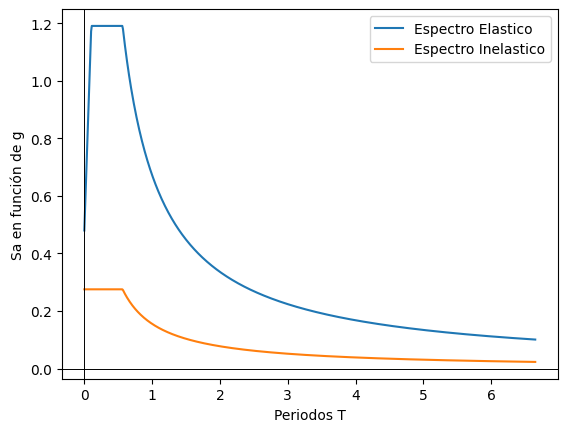

In [223]:
Spec, SpecI, Tmp, To, Tc, Tl = BN.Spec_NEC(n, z, fa, fd, fs, rr, Imp, R, fip, fie, 2.5)

fig, ax = plt.subplots()
plt.plot(Tmp, Spec[:,1], label='Espectro Elastico')
plt.plot(Tmp, SpecI[:,1], label='Espectro Inelastico')
ax.axhline(0, color='black', linewidth=0.7)
ax.axvline(0, color='black', linewidth=0.7)
ax.set_xlabel('Periodos T')
ax.set_ylabel('Sa en función de g')
plt.legend()
plt.show()

In [224]:
tbl_SpecI = pd.DataFrame(SpecI)
#display(tbl_SpecI.style.set_caption('Sa_Espectro Inelastico'))

In [225]:
#Matrices de Masa y Rigidez

K, M, k = BN.K_M(num_col, H, E, tipo, I, vector, m, coef_castigo)
#print(K)
#print(M)

K_tbl = pd.DataFrame(K)
display(K_tbl.style.set_caption('Matriz de rigidez'))

,0,1,2,3
0,225.185185,-112.592593,0.000000,0.000000
1,-112.592593,225.185185,-112.592593,0.000000
2,0.000000,-112.592593,225.185185,-112.592593
3,0.000000,0.000000,-112.592593,112.592593


In [226]:
M_tbl = pd.DataFrame(M)
display(M_tbl.style.set_caption('Matriz de masas (Tons)'))

,0,1,2,3
0,11.314985,0.000000,0.000000,0.000000
1,0.000000,11.314985,0.000000,0.000000
2,0.000000,0.000000,11.314985,0.000000
3,0.000000,0.000000,0.000000,11.314985


In [227]:
#EIGENVECTORES Y EIGENVALORES
# Minv = np.linalg.inv(M)
# A = Minv @ (K)
# V, D = eig(A)

# V = V.real
# D = np.transpose(D)
V, D = eigh(K, M)  #scipy
# K = np.array(K).astype(float)  #numpy
# M = np.array(M).astype(float)  #numpy
# V, D = np.linalg.eig(np.linalg.inv(M).dot(K))  #numpy

w = np.sqrt(V)
T = 2*np.pi/w

df_wTD = pd.DataFrame({'w': w, 'T': T, 'V': V})
display(df_wTD)

,w,T,V
0,1.095540,5.735242,1.200207
1,3.154481,1.991829,9.950751
2,4.832945,1.300074,23.357361
3,5.928485,1.059830,35.146936


In [228]:
tbl_D = pd.DataFrame(D)
display(tbl_D.style.set_caption('Modos de vibracion:'))

,0,1,2,3
0,0.067785,0.171638,-0.195179,-0.127394
1,0.127394,0.171638,0.067785,0.195179
2,0.171638,-0.000000,0.171638,-0.171638
3,0.195179,-0.171638,-0.127394,0.067785


In [229]:
Sa_I = []
for i in range(len(V)):
    Sa_I.append(SpecI[np.where(SpecI[:,0] == round(T[i],2))[0], 1])

tbl_Sa_I = pd.DataFrame(Sa_I)
display(tbl_Sa_I.style.set_caption('Sa_I'))

,0
0,0.027110
1,0.078196
2,0.119700
3,0.146802


In [230]:
#Valor de aceleraciones espectrales correpondiente a T [Fracción de la gravedad]

Lw = np.zeros(len(T))
for i in range(len(T)):
    Lw[i] = D[:, i].T @ M @ r

df_Lw = pd.DataFrame(Lw, columns=["Lw"])
display(df_Lw)

,Lw
0,6.358973
1,1.942077
2,-0.940848
3,-0.408105


In [231]:
#Factor de excitación sísmica modal

MT = np.sum(np.diag(M))
M_e = np.zeros(len(T))

for i in range(len(T)):
    M_e[i] = ((Lw[i]**2) / MT) * 100

df_M_e = pd.DataFrame(M_e)
display(df_M_e.style.set_caption('Masas efectivas'))

,0
0,89.342882
1,8.333333
2,1.955801
3,0.367984


In [232]:
#Masa efectiva [%]

M_eacum = []
M_eacum.append(M_e[0])

for i in range(len(T)-1):
    M_eacum.append(M_eacum[i] + M_e[i+1])

df_M_eacum = pd.DataFrame(M_eacum)
display(df_M_eacum.style.set_caption('Masas efectivas acumuladas'))

,0
0,89.342882
1,97.676215
2,99.632016
3,100.000000


In [233]:
#b = int(input("Número de modos de vibración para la superposición (ver M_eacum al 90%): "))

In [234]:
#Respuestas maximas modales
g = 9.8
qmax = np.zeros((gdl,gdl))
for i in range(gdl):
    qmax[:,i] = ((Lw[i]*Sa_I[i]*g)/(V[i]))*(D[:,i])

tbl_qmax = pd.DataFrame(qmax)
display(tbl_qmax.style.set_caption('qmax'))

,0,1,2,3
0,0.095415,0.025670,0.009222,0.002128
1,0.179321,0.025670,-0.003203,-0.003260
2,0.241598,-0.000000,-0.008110,0.002867
3,0.274735,-0.025670,0.006020,-0.001132


In [235]:
#Fuerzas Elásticas Máximas Modales ("Tiene Unidad")
Qmax = np.zeros((gdl,gdl))
for i in range(gdl):
    Qmax[:,i] = (Lw[i]*Sa_I[i]*g*M[i,i]*D[:,i])

tbl_qmax = pd.DataFrame(Qmax)
display(tbl_qmax.style.set_caption('Qmax'))

,0,1,2,3
0,1.295762,2.890296,2.437394,0.846314
1,2.435235,2.890296,-0.846498,-1.296629
2,3.280984,-0.000000,-2.143408,1.140236
3,3.730997,-2.890296,1.590896,-0.450314


In [236]:
#Superposición modal
#SRSS(Raíz cuadrada de la suma de los cuadrados)  &  #ABS(Suma)
b = gdl
SR = np.zeros((gdl,b))
abz = np.zeros((gdl,b))
for i in range(gdl):
    for j in range(b):
        SR[i,j] = (Qmax[i,j]**2) + SR[i,j]
        abz[i,j] = np.abs(Qmax[i,j]) + abz[i,j]

SRSS = np.sqrt(SR)
aux33 = [abz,SRSS]

tbl_abz = pd.DataFrame(abz)
tbl_SRSS = pd.DataFrame(SRSS)
display(tbl_abz.style.set_caption("ABZ"))
display(tbl_SRSS.style.set_caption("SRSS"))

,0,1,2,3
0,1.295762,2.890296,2.437394,0.846314
1,2.435235,2.890296,0.846498,1.296629
2,3.280984,0.000000,2.143408,1.140236
3,3.730997,2.890296,1.590896,0.450314


,0,1,2,3
0,1.295762,2.890296,2.437394,0.846314
1,2.435235,2.890296,0.846498,1.296629
2,3.280984,0.000000,2.143408,1.140236
3,3.730997,2.890296,1.590896,0.450314


In [237]:
#Distribución del cortante basal por piso
F = ((SRSS+abz)/2)

tbl_F = pd.DataFrame(F)
display(tbl_F.style.set_caption('Distribución del cortante basal por piso'))

modo_vibracion = 0 #¡¡¡ Debe ser estrictamente INFERIOR AL NUMERO DE MODOS DE VIBRACION ESCOGIDOS "<= b-1" !!!

#Cortante Basal Maximo
print(f'El cortante basal máximo: {np.sum(F[:,modo_vibracion])}')

#Porcentaje de acuerdo al peso del edificio
p = MT*g
Porc =np.sum(F[:,modo_vibracion])*100/p
print(f'El Porcentaje de acuerdo al peso del edificio: {Porc}')

#Forma de la fuerza Normalizada para 3 modos de vibracion
F_n = []
for i in range(gdl):
    F_n.append(F[i,modo_vibracion]/np.max(F[:,modo_vibracion]))

# F = [item for sublist in F for item in sublist]
# F_n = [item for sublist in F_n for item in sublist]
tbl_F_n = pd.DataFrame(F_n)
display(tbl_F_n.style.set_caption('Forma de la fuerza normalizada'))

,0,1,2,3
0,1.295762,2.890296,2.437394,0.846314
1,2.435235,2.890296,0.846498,1.296629
2,3.280984,0.000000,2.143408,1.140236
3,3.730997,2.890296,1.590896,0.450314


El cortante basal máximo: 10.742977733402965
El Porcentaje de acuerdo al peso del edificio: 2.422058548554033


,0
0,0.347296
1,0.652704
2,0.879385
3,1.000000


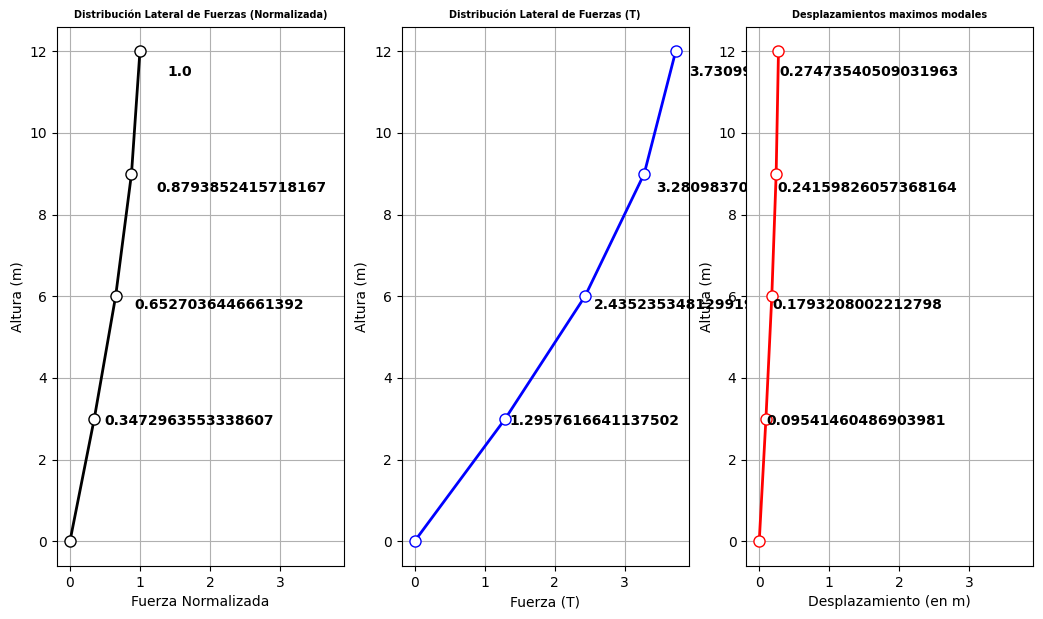

In [238]:
Hacum = np.zeros(gdl)
Hacum[0] = H[0]

for i in range(gdl):
    Hacum[i] = Hacum[i - 1] + H[i]

graf = np.zeros((gdl, 3))

for i in range(gdl):
    graf[i, 0] = F_n[i]
    graf[i, 1] = Hacum[i]
    graf[i, 2] = qmax[i,modo_vibracion]

graf = np.vstack(([0, 0, 0], graf))

escala = 7
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(escala*1.8, escala))

# First subplot
ax1.plot(graf[:, 0], graf[:, 1], '-ok', markersize=8, markerfacecolor='w', linewidth=2)
ax1.grid(True)
ax1.set_title('Distribución Lateral de Fuerzas (Normalizada)', fontweight='bold', fontsize=escala)
ax1.set_xlabel('Fuerza Normalizada')
ax1.set_ylabel('Altura (m)')

for i in range(len(graf) - 1):
    ax1.text(graf[i + 1, 0] * 1.4, graf[i + 1, 1] * 0.95, str(graf[i + 1, 0]), fontsize=10, fontweight='bold')


# Second subplot
ax2.plot(graf[:, 0] * F[-1,modo_vibracion], graf[:, 1], '-ob', markersize=8, markerfacecolor='w', linewidth=2)
ax2.grid(True)
ax2.set_title('Distribución Lateral de Fuerzas (T)', fontweight='bold', fontsize=escala)
ax2.set_xlabel('Fuerza (T)')
ax2.set_ylabel('Altura (m)')

for i in range(len(graf) - 1):
    ax2.text(graf[i + 1, 0] * F[-1,modo_vibracion] * 1.05, graf[i + 1, 1] * 0.95, str(graf[i + 1, 0] * F[-1,modo_vibracion]), fontsize=10, fontweight='bold')

# Third subplot
ax3.plot(graf[:, 2], graf[:, 1], '-or', markersize=8, markerfacecolor='w', linewidth=2)
ax3.grid(True)
ax3.set_title('Desplazamientos maximos modales', fontweight='bold', fontsize=escala)
ax3.set_xlabel('Desplazamiento (en m)')
ax3.set_ylabel('Altura (m)')

for i in range(len(graf) - 1):
    ax3.text(graf[i + 1, 2] * 1.05, graf[i + 1, 1] * 0.95, str(graf[i + 1, 2]), fontsize=10, fontweight='bold')

plt.show()

In [239]:
#Calculo de Derivas
Derivas = []
qmax = np.vstack((np.zeros(gdl), qmax))
for i in range(gdl):
    Derivas.append((qmax[i+1,modo_vibracion]-qmax[i,modo_vibracion])/H[0]*100)

Derivas = np.flip(Derivas)
Derivas_Pisos = np.column_stack((np.flip(np.arange(1, gdl+1)), Derivas))
tbl_Derivas = pd.DataFrame(Derivas_Pisos)
display(tbl_Derivas.style.set_caption('Derivas (%)'))

,0,1
0,4.000000,1.104571
1,3.000000,2.075915
2,2.000000,2.796873
3,1.000000,3.180487


In [240]:
c1 = 0.2
c2 = 0.3
num_columnas = 9
pisos = 3
altura_entrepiso = 3
print(f'vol_columnas20 es: {c1*c1*num_columnas*pisos*altura_entrepiso} m3')
print(f'vol_columnas30 es: {c2*c2*num_columnas*pisos*altura_entrepiso} m3')

vol_columnas20 es: 3.240000000000001 m3
vol_columnas30 es: 7.289999999999999 m3
